In [3]:
import os
os.chdir('/home/dk/CrunchProjects/demand_prediction_v2/data/raw')

In [4]:
os.listdir(os.getcwd())

['Verklarende_lijst.xlsx', 'csvs', '.gitkeep', 'txts', 'parquets']

## Basic File Inspection

In [9]:
# !mkdir txts
# !mkdir csvs
# !mv *.txt ./txts/

### Check out size of files and their extensions

In [10]:
!ls -l ./txts/ --block-size=MB

total 4425MB
-rw-r--r-- 1 dk dk   48MB Jan  9 12:47 Item.txt
-rw-r--r-- 1 dk dk    1MB Sep  5  2016 Licenties.txt
-rw-r--r-- 1 dk dk   32MB Jan  9 12:47 Promo.txt
-rw-r--r-- 1 dk dk   16MB Jan  9 12:47 PurchaseLine.txt
-rw-r--r-- 1 dk dk 4127MB Jan  9 13:12 Sales.txt
-rw-r--r-- 1 dk dk  201MB Jan  9 12:49 Stock_Export_CCF_CCO.txt
-rw-r--r-- 1 dk dk    3MB Jan  9 12:47 Stockouts.txt


- Count number of rows

In [11]:
os.chdir('/home/dk/CrunchProjects/demand_prediction_v2/data/raw/txts/')
!ls | xargs wc -l

    267365 Item.txt
        99 Licenties.txt
    281473 Promo.txt
    223426 PurchaseLine.txt
  17661125 Sales.txt
   2886339 Stock_Export_CCF_CCO.txt
     43799 Stockouts.txt
  21363626 total


### Take a look at the files

- Take note of
    - the delimiter
    - decimal point separator
    - any missing data
    - ID columns
    - DateTime encodings

In [12]:
!head -n 5 Sales.txt

In [13]:
!head -n 5 Item.txt

In [16]:
!head -n 5 Promo.txt

In [17]:
!head -n 5 PurchaseLine.txt

In [19]:
!head -n 5 Stockouts.txt

In [21]:
!head -n 5 Stock_Export_CCF_CCO.txt

In [22]:
!head -n 5 Licenties.txt

Code	Omschrijving
ANGRYBIRDS	Angry Birds
ANT-MAN	Ant-Man
AVENGERS	Avengers
BARBIE	Barbie


### Column Names

In [23]:
!head -n 1 Sales.txt | tr "|" "\n" | nl | pr -t -2

     1	POSSales_PK		    	11	POSSales_Sales Quantity
     2	Date_FK			    	12	POSSales_Sales AmountExVAT
     3	Date			    	13	POSSales_Sales AmountInVAT
     4	Store_FK		    	14	POSSales_Cost Amount
     5	Item_FK			    	15	POSSales_Margin Amount
     6	Item_PK			    	16	POSSales_Discount Amount
     7	Promo_FK		    	17	Store No_BK
     8	POSSales_Ticket No	    	18	POS Terminal No_BK
     9	POSSales_GiftList No	    	19	Transaction No_BK



# 0. Check if files have non-alphanumeric characters

- These create errors when imported into R/Pandas (they work with UTF-8)
- See this [link](https://www.polydesmida.info/cookbook/encoding1.html) for help

In [25]:
!awk \
'BEGIN {FS=""} \
{for (i=1;i<=NF;i++) \
    if ($i ~ /[^[:alnum:]]/) \
        {arr[$i]++}} \
END {for (j in arr) printf("%7s %s\n",arr[j],j)}' ../txts/Item.txt | sort -k2 | pr -t -4

      2 `	  1077233 ,	       4978 (	      	 3335 #
      1 ~	       31 ;	       4779 )	      	  618 %
     18 <	     7074 :	    	  2 [	      	 6940 +
    135 =	      832 !	    	  2 ]	      	   13 �
     24 >	      259 ?	    	 24 @	      	82421 
4277824 |	    23771 /	    	  3 $	      	    8 
1500543		   126453 .	    	754 *	       115206 
   1019 _	     8434 '	    	  1 \	      	  107 



- Observe that in the last column, there are a lot of characters that cannot be interpreted (at least on my machine)
- To deal with these, one strategy is to convert them to placeholder characters (like #)


## a. Use `uchardet` to figure out the character encoding of your file

- needs to be installed

In [27]:
!uchardet ../txts/Sales.txt

ascii/unknown


In [26]:
!uchardet ../txts/Item.txt

ascii/unknown


## b. Use `iconv` for converting to `UTF-8`

- part of GNU coreutils (available on most Linux machines)
- Here's the `man` [page](https://www.gnu.org/savannah-checkouts/gnu/libiconv/documentation/libiconv-1.15/iconv.1.html)
- Get a list of supported encodings with `iconv -l`

Syntax
```bash
iconv -f ASCII -t UTF-8 --unicode-subst="<#>" --byte-subst="<#>" foo > bar
```

In [29]:
!iconv -f ascii -t utf-8 --byte-subst="<#>" ../txts/Item.txt > ../txts/Item2.txt
# replace any character that cannot be converted by a <#> placeholder

!wc -l ../txts/Item2.txt
!rm ../txts/Item.txt
!mv ../txts/Item2.txt ../txts/Item.txt
!wc -l ../txts/Item.txt

267365 ../txts/Item2.txt
267365 ../txts/Item.txt


---
# 1. Fix colnames, delimiter (convert to csv)

- Convert Pipe delimited .txt file to a .csv
- Convert decimal serparator from comma , to dot .
- Convert spaces in colnaes them to underscores and lowercase of them consistency

### Method 1 - FOR VERY LARGE (>3GB) FILES

In [112]:
# replace spaces by underscores, and pipes by commas
!head -n 1 ../txts/Sales.txt \
| tr '| ' ',_' \
| tr '[:upper:]' '[:lower:]' > ../csvs/Sales.csv

# Replace the delimiter and append the headless file to the file created above
!cat ../txts/Sales.txt \
| sed '1d' \
| tr ',|' '.,' >> ../csvs/Sales.csv

In [121]:
!head -n 1 ../txts/Item.txt \
| tr '| ' ',_' \
| tr '[:upper:]' '[:lower:]' > ../csvs/Item.csv

!cat ../txts/Item.txt \
| sed '1d' \
| tr ',|' '.,' >> ../csvs/Item.csv

### Method 2 - For Medium Sized Files

In [56]:
# better put this in a loop
!cat ../txts/Promo.txt \
| awk '{if(NR==1) \
            {gsub(" ", "_");  gsub("\\|", ","); print tolower($0)} \
        else \
            {gsub(",", "."); gsub("\\|", ","); print $0}\
        }' \
> ../csvs/Promo.csv

!cat ../txts/Stock_Export_CCF_CCO.txt \
| awk '{if(NR==1) \
            {gsub(" ", "_");  gsub("\\|", ","); print tolower($0)} \
        else \
            {gsub(",", "."); gsub("\\|", ","); print $0}\
        }' \
> ../csvs/Inventory.csv

!cat Stockouts.txt \
| awk '{if(NR==1) \
            {gsub(" ", "_");  gsub("\\|", ","); print tolower($0)} \
        else \
            {gsub(",", "."); gsub("\\|", ","); print $0}\
        }' \
> ../csvs/Stockouts.csv 

---

**FOR SMALLER FILES (Under 1GB)**

```bash
# all of the above in one line, but 30x slower
mlr --csv --ifs '|' rename -g -r ' ,_' Fun__Sales.txt > Fun_Sales.csv

# a little faster
!head -n 2 Fun__Sales.txt | mlr --csv --ifs '|' rename -g -r ' ,_' > Fun_Sales.csv
!mlr --csv --ifs '|' cat Fun__Sales.txt | sed '1,2d' >> Fun_Sales.csv 
```
---

---

# 2. Subset, Rename, Format Columns, Impute Missings

In [130]:
os.chdir("../csvs/")
!ls | xargs wc -l

   2886339 Inventory.csv
    267365 Item.csv
    281473 Promo.csv
  17661125 Sales.csv
     43799 Stockouts.csv
  21140101 total


In [ ]:
# Sales file
! cat Sales.csv \
| csvtk cut -f date,store_no_bk,item_pk,possales_sales_quantity,possales_sales_amountinvat \
| csvtk rename -f 1-5 -n date,store_id,product_id,qty,amt \
| numfmt --delimiter=, --field=4,5 --format='%0.2f' --header=1 \
> Sales_2.csv

!rm Sales.csv
!mv Sales_2.csv Sales.csv

In [131]:
!head Sales.csv | csvlook

|----------------------+----------+------------+------+--------|
|  date                | store_id | product_id | qty  | amt    |
|----------------------+----------+------------+------+--------|
|  2014-01-02 00:00:00 | S038     | 20337325   | 1.00 | 20.96  |
|  2014-01-02 00:00:00 | S038     | 20194564   | 1.00 | 52.49  |
|  2014-01-02 00:00:00 | S038     | 20347663   | 1.00 | 7.99   |
|  2014-01-02 00:00:00 | S038     | 20332760   | 1.00 | 29.99  |
|  2014-01-02 00:00:00 | S038     | 20181754   | 1.00 | 14.99  |
|  2014-01-02 00:00:00 | S038     | 20064602   | 1.00 | 1.00   |
|  2014-01-02 00:00:00 | S038     | 20091889   | 1.00 | 2.69   |
|  2014-01-02 00:00:00 | S038     | 20314299   | 1.00 | 12.95  |
|  2014-01-02 00:00:00 | S038     | 20194803   | 1.00 | 3.99   |
|----------------------+----------+------------+------+--------|


In [124]:
# Item file
!head -2 Item.csv \
| mlr --csv rename no_,product_id \
| sed '2d' \
> ../csvs/Item_2.csv

!cat Item.csv \
| awk 'NR>1' \
| tr -d '\r' \
| awk -F, 'BEGIN {OFS=","} \
{ \
{if($6=="") $6=0} \
{if($7=="") $7=0} \
{if($16=="") $16=0} \
{if($17=="") $17=0} \
{print $0} \
}' \
| numfmt --delimiter=, --field=6,7,16,17 --format='%0.2f' --header=1 \
>> Item_2.csv

!rm Item.csv
!mv Item_2.csv Item.csv

In [136]:
!head Item.csv | cut -d, -f1-3 | csvlook

|-------------+----------------------------------------------------+-------------|
|  product_id | description                                        | vendor_no_  |
|-------------+----------------------------------------------------+-------------|
|  20023400   | RAYHER PARELMOER-STOFFENVERF - WIT - FLACON 29 ML  | L20714      |
|  20023401   | RAYHER METALLIC TEXTIELVERF - CITROEN              | L20714      |
|  20023402   | RAYHER PARELMOER-STOFFENVERF - GOUDGEEL - FLACON   | L20714      |
|  20023404   | RAYHER PATIO-PAINT - 8 BASISTINTEN OP BLISTERKAART | L20714      |
|  20023405   | RAYHER PARELMOER-STOFFENVERF - KARDINAALROOD -     | L20714      |
|  20023407   | RAYHER PARELMOER-STOFFENVERF - ROYALBLAUW - FLACON | L20714      |
|  20023409   | RAYHER PARELMOER-STOFFENVERF - ZEEGROEN - FLACON   | L20714      |
|  20023410   | DISNEY COLOR PARADE THE INCREDIBLES                | L10426      |
|  20023411   | RAYHER PARELMOER-STOFFENVERF-ZILVER- FLACON 29 ML  | L20714      |
|---

In [137]:
# Stockouts file

!csvtk rename -f1-5 -n product_id,location_code,date_oos,date_is,days_oos Stockouts.csv \
> Stockouts_2.csv

!rm Stockouts.csv
!mv Stockouts_2.csv Stockouts.csv

!head Stockouts.csv | csvlook

|-------------+---------------+---------------------+---------------------+-----------|
|  product_id | location_code | date_oos            | date_is             | days_oos  |
|-------------+---------------+---------------------+---------------------+-----------|
|  044407     | CCF           | 2014-08-06 00:00:00 | 2014-09-28 00:00:00 | 53        |
|  044407     | CCF           | 2014-12-22 00:00:00 | 2014-12-31 00:00:00 | 9         |
|  044407     | CCF           | 2015-01-07 00:00:00 | 2015-01-12 00:00:00 | 5         |
|  044407     | CCF           | 2015-02-21 00:00:00 | 2015-03-04 00:00:00 | 11        |
|  044407     | CCF           | 2015-05-28 00:00:00 | 2015-06-04 00:00:00 | 7         |
|  044407     | CCF           | 2015-11-29 00:00:00 | 2015-12-02 00:00:00 | 3         |
|  044407     | CCF           | 2015-12-24 00:00:00 | 2015-12-30 00:00:00 | 6         |
|  044407     | CCF           | 2016-01-10 00:00:00 | 2016-01-13 00:00:00 | 3         |
|  044407     | CCF           | 

In [140]:
# Promo file

!cat Promo.csv \
| numfmt --delimiter=, --field=3,4 --format='%0.2f' --header=1 \
| mlr --csv rename item_no_,product_id \
> Promo_2.csv

!rm Promo.csv
!mv Promo_2.csv Promo.csv

!head Promo.csv | cut -d, -f1-4 | csvlook

|----------------+------------+------------------+------------------------|
|  promotion_no_ | product_id | unit_price_(lcy) | promotion_price_(lcy)  |
|----------------+------------+------------------+------------------------|
|  BDAYFUN16C    | 20193590   | 12.99            | 10.40                  |
|  BDAYFUN16C    | 20193593   | 5.99             | 4.81                   |
|  BDAYFUN16C    | 20193594   | 2.99             | 2.41                   |
|  BDAYFUN16C    | 20193598   | 4.99             | 4.00                   |
|  BDAYFUN16C    | 20193600   | 4.99             | 4.00                   |
|  BDAYFUN16C    | 20193602   | 2.50             | 2.00                   |
|  BDAYFUN16C    | 20193611   | 30.00            | 24.00                  |
|  BDAYFUN16C    | 20193617   | 3.99             | 3.20                   |
|  BDAYFUN16C    | 20193619   | 6.00             | 4.81                   |
|----------------+------------+------------------+------------------------|


In [141]:
# Inventory

! cat Inventory.csv \
| numfmt --delimiter=, --field=5 --format='%0.2f' --header=1 \
| mlr --csv rename item_no_,product_id \
> Inventory_2.csv

!rm Inventory.csv
!mv Inventory_2.csv Inventory.csv

!head Inventory.csv | cut -d, -f1-6 | csvlook

|------------+---------------------+---------------+------------+----------+-------------|
|  entry_no_ | posting_date        | location_code | product_id | quantity | entry_type  |
|------------+---------------------+---------------+------------+----------+-------------|
|  248357577 | 2016-10-26 00:00:00 | CCF           | 20386379   | -1.00    | 1           |
|  248363107 | 2016-10-26 00:00:00 | CCF           | 20400579   | 1.00     | 2           |
|  248363108 | 2016-10-26 00:00:00 | CCF           | 20387536   | -1.00    | 3           |
|  248363158 | 2016-10-26 00:00:00 | CCF           | 20400577   | -1.00    | 3           |
|  248363343 | 2016-10-26 00:00:00 | CCF           | 20400599   | 4.00     | 4           |
|  248363443 | 2016-10-26 00:00:00 | CCF           | 20396787   | 12.00    | 4           |
|  248363493 | 2016-10-26 00:00:00 | CCF           | 20386796   | 10.00    | 4           |
|  248363593 | 2016-10-26 00:00:00 | CCF           | 20394160   | 6.00     | 4           |

# Subset Rows

----

### for Merksem (ID: S031) and the Web Store (ID: S092)

In [142]:
!cat Sales.csv \
| csvtk filter2 -f '$store_id=="S031" || $store_id=="S092"' \
> Sales_2.csv

!rm Sales.csv
!mv Sales_2.csv Sales.csv

!head Sales.csv | csvlook

|----------------------+----------+------------+------+--------|
|  date                | store_id | product_id | qty  | amt    |
|----------------------+----------+------------+------+--------|
|  2014-01-02 00:00:00 | S092     | 20337578   | 1.00 | 49.99  |
|  2014-01-02 00:00:00 | S092     | 20311939   | 1.00 | 44.99  |
|  2014-01-02 00:00:00 | S092     | 20333446   | 1.00 | 49.99  |
|  2014-01-02 00:00:00 | S092     | 20177425   | 1.00 | 24.99  |
|  2014-01-02 00:00:00 | S092     | 20325858   | 1.00 | 40.00  |
|  2014-01-02 00:00:00 | S092     | 20327913   | 1.00 | 11.99  |
|  2014-01-02 00:00:00 | S092     | 20300821   | 1.00 | 21.99  |
|  2014-01-02 00:00:00 | S092     | 20337572   | 1.00 | 19.99  |
|  2014-01-02 00:00:00 | S092     | 20177397   | 1.00 | 29.99  |
|----------------------+----------+------------+------+--------|


In [213]:
!cat ../txts/Sales.txt \
| datamash -sHi -t"|" --group 17 count 17 \
| tr "|" "," \
| awk -F, 'BEGIN {OFS=","} {if($1=="S031" || $1=="S092") {print $0}}' \
| csvtk pretty

S031   1117638
S092   267960


---

# Random Sampling

In [151]:
# 1% sample
!head -n 1 Sales.csv > Sales_Sample.csv
!cat Sales.csv | sed '1d' | shuf -n 10000 >> Sales_Sample.csv

!head Sales_Sample.csv | csvlook

|----------------------+----------+------------+------+---------|
|  date                | store_id | product_id | qty  | amt     |
|----------------------+----------+------------+------+---------|
|  2014-09-27 00:00:00 | S031     | 20366629   | 1.00 | 3.99    |
|  2014-01-29 00:00:00 | S031     | 20306026   | 4.00 | 11.96   |
|  2014-12-22 00:00:00 | S031     | 20333376   | 1.00 | 40.00   |
|  2015-03-19 00:00:00 | S092     | 20374212   | 1.00 | 259.00  |
|  2014-12-01 00:00:00 | S031     | 20363754   | 1.00 | 38.00   |
|  2014-05-03 00:00:00 | S092     | 20332732   | 1.00 | 46.74   |
|  2015-06-21 00:00:00 | S031     | 641250     | 1.00 | 0.80    |
|  2014-12-22 00:00:00 | S031     | 20368490   | 1.00 | 59.99   |
|  2015-03-13 00:00:00 | S031     | 20192498   | 1.00 | 2.25    |
|----------------------+----------+------------+------+---------|


In [152]:
# one-liner using csvtk (preserves the header row) [slower]
!csvtk sample -p 0.001 Sales.csv > Sales_Sample2.csv

In [153]:
!rm Sales_Sample.csv Sales_Sample2.csv

## Get unique values for dates

> Type conversion of dates is quite painful in large files. So here's the proposed workflow
1. Get a list of all unique values (usually in the low 1000s)
2. Add a column to this list; create a lookup table 
3. Join this to the original csv.

In [ ]:
# Create a new directory to store unique values
!mkdir unqs

In [157]:
# Sales

!csvtk uniq -f date Sales.csv \
| csvtk cut -f date > ./unqs/uniqs__dates_sales.csv

!wc -l ./unqs/uniqs__dates_sales.csv

1097 ./unqs/uniqs__dates_sales.csv


In [159]:
# Inventory 

!csvtk uniq -f posting_date Inventory.csv \
| csvtk cut -f posting_date > ./unqs/uniqs__Posting_Dates_inventory.csv

!wc -l ./unqs/uniqs__Posting_Dates_inventory.csv

4319 ./unqs/uniqs__Posting_Dates_inventory.csv


In [160]:
# Yes, we can write python here too (it's a python notebook afterall)
# Ah, the beauty of Jupyter!

import pandas as pd
def createDateLookups(infile='', outfile='', datecols=[]):
    """
    Creates a date lookup csv file
    Converts dates stored as text to pandas datetime
    If there's an error in conversion, that value is imputed by 1970-01-01
    """
    df_date = pd.read_csv(infile)
    
    print 'Unique Dates in {} = {}'.format(infile, df_date.shape[0])

    for COL in datecols:
        # Create new column
        df_date['pd_' + COL] = pd.to_datetime(df_date[COL], errors='coerce').fillna(pd.to_datetime('1970-01-01'))
        df_date['pd_yr_mon_' + COL] = (df_date['pd_' + COL]
                                       .map(lambda x: str(x.year) + '-' + str(x.month).zfill(2)))
    
    df_date.to_csv(outfile, index=False)
    print outfile + ' created'

In [161]:
createDateLookups(infile='./unqs/uniqs__dates_sales.csv', 
                  outfile='./date_lookup_sales.csv',
                  datecols=['date'])

Unique Dates in ./unqs/uniqs__dates_sales.csv = 1096
./date_lookup_sales.csv created


In [163]:
createDateLookups(infile='./unqs/uniqs__Posting_Dates_inventory.csv', 
                  outfile='./date_lookup_inventory.csv',
                  datecols=['posting_date'])

Unique Dates in ./unqs/uniqs__Posting_Dates_inventory.csv = 4318
./date_lookup_inventory.csv created


---

### $Note$ <br> **In other projects, date columns could be formatted as Epoch timestamps or something else entirely. This approach should still remain valid, conversion of dates within Python should be simple enough.**

---

---
# Join / Merge

In [164]:
# if the primary key has different names, use "t1_key;t2_key"
!csvtk join -f posting_date Inventory.csv date_lookup_inventory.csv \
|cut -d, -f1,3-8 \
> Inventory_2.csv


!rm Inventory.csv
!mv Inventory_2.csv Inventory.csv

In [181]:
!head Inventory.csv | cut -d, -f1,5-8 | csvlook

|------------+------------+-----------------+-------------------------|
|  entry_no_ | entry_type | pd_posting_date | pd_yr_mon_posting_date  |
|------------+------------+-----------------+-------------------------|
|  248357577 | 1          | 2016-10-26      | 2016-10                 |
|  248363107 | 2          | 2016-10-26      | 2016-10                 |
|  248363108 | 3          | 2016-10-26      | 2016-10                 |
|  248363158 | 3          | 2016-10-26      | 2016-10                 |
|  248363343 | 4          | 2016-10-26      | 2016-10                 |
|  248363443 | 4          | 2016-10-26      | 2016-10                 |
|  248363493 | 4          | 2016-10-26      | 2016-10                 |
|  248363593 | 4          | 2016-10-26      | 2016-10                 |
|  248363643 | 4          | 2016-10-26      | 2016-10                 |
|------------+------------+-----------------+-------------------------|


In [167]:
# if the primary key has different names, use "t1_key;t2_key"
!csvtk join -f date Sales.csv date_lookup_sales.csv \
|cut -d, -f2-7 \
> Sales_2.csv


!rm Sales.csv
!mv Sales_2.csv Sales.csv
!head Sales.csv | csvlook

|-----------+------------+------+-------+------------+-----------------|
|  store_id | product_id | qty  | amt   | pd_date    | pd_yr_mon_date  |
|-----------+------------+------+-------+------------+-----------------|
|  S092     | 20337578   | 1.00 | 49.99 | 2014-01-02 | 2014-01         |
|  S092     | 20311939   | 1.00 | 44.99 | 2014-01-02 | 2014-01         |
|  S092     | 20333446   | 1.00 | 49.99 | 2014-01-02 | 2014-01         |
|  S092     | 20177425   | 1.00 | 24.99 | 2014-01-02 | 2014-01         |
|  S092     | 20325858   | 1.00 | 40.00 | 2014-01-02 | 2014-01         |
|  S092     | 20327913   | 1.00 | 11.99 | 2014-01-02 | 2014-01         |
|  S092     | 20300821   | 1.00 | 21.99 | 2014-01-02 | 2014-01         |
|  S092     | 20337572   | 1.00 | 19.99 | 2014-01-02 | 2014-01         |
|  S092     | 20177397   | 1.00 | 29.99 | 2014-01-02 | 2014-01         |
|-----------+------------+------+-------+------------+-----------------|


## Lists of Uniques

In [168]:
# sold products

!cat Sales.csv \
| csvtk cut -f product_id \
| csvtk uniq \
> ./unqs/uniqs__productids_sales.csv

In [169]:
!wc -l ./unqs/uniqs__productids_sales.csv

56665 ./unqs/uniqs__productids_sales.csv


## Basic EDA

In [180]:
!head -n 1 Item.csv | tr "," "\n" | nl

     1	product_id
     2	description
     3	vendor_no_
     4	vendor_name
     5	license
     6	unit_cost
     7	current_sales_price
     8	item_status
     9	web_shop_item
    10	item_category_code
    11	product_group_code
    12	product_subgroup
    13	universe
    14	lead_time_calculation
    15	review_time_calculation
    16	pick



### What % of items under each item status are webshopitems?

In [230]:
!cat Item.csv  \
| awk -F, 'BEGIN {OFS=","} {if ($9!="" && $9!=34) {print $0}}' \
| datamash -sHi -t"," --group 8 countunique 1 mean 9 \
| csvtk rename -f 1-3 -n item_status,nunique__product_ids,mean_webshopitem \
| numfmt --delimiter=, --field=3 --format='%0.3f' --header=1 \
| csvlook

|--------------+----------------------+-------------------|
|  item_status | nunique__product_ids | mean_webshopitem  |
|--------------+----------------------+-------------------|
|              | 26                   | 0.000             |
|  0           | 371                  | 0.362             |
|  1           | 15868                | 0.425             |
|  2           | 2023                 | 0.793             |
|  3           | 2344                 | 0.728             |
|  4           | 1745                 | 0.355             |
|  5           | 5981                 | 0.844             |
|  6           | 12489                | 0.204             |
|  8           | 28513                | 0.340             |
|  9           | 198002               | 0.045             |
|--------------+----------------------+-------------------|


### Find the date of introduction of each product_id 

In [231]:
!head -n 1 Inventory.csv | tr "," "\n" | nl

     1	entry_no_
     2	location_code
     3	product_id
     4	quantity
     5	entry_type
     6	pd_posting_date
     7	pd_yr_mon_posting_date


In [267]:
!cat Inventory.csv \
| csvtk sort -k 3,6 \
| datamash -H -t, --group 3 first 6 sum 4 \
| csvtk rename -f1-3 -n product_id,date_introduced,sum__quantity \
> date__product_id_introduced.csv

In [268]:
!head date__product_id_introduced.csv | csvlook

|-------------+-----------------+----------------|
|  product_id | date_introduced | sum__quantity  |
|-------------+-----------------+----------------|
|  000066     | 2012-01-14      | 0              |
|  000170     | 2009-10-01      | 0              |
|  000387     | 2010-09-28      | 0              |
|  000435     | 2008-09-29      | 1              |
|  000549     | 2013-10-01      | 0              |
|  000723     | 2004-03-29      | 0              |
|  001908     | 2008-03-10      | 0              |
|  002622     | 2012-10-12      | 0              |
|  003210     | 1970-01-01      | 1              |
|-------------+-----------------+----------------|


## product_ids with Negative Stock

In [279]:
!cat date__product_id_introduced.csv \
| awk -F, '{if($3<0){print $1}}' \
| wc -l

966


## First Sale Date

In [269]:
!head -n 1 Sales.csv | tr "," "\n" | nl

     1	store_id
     2	product_id
     3	qty
     4	amt
     5	pd_date
     6	pd_yr_mon_date


In [270]:
!cat Sales.csv \
| csvtk sort -k 2,5 \
| datamash -H -t, --group 2 first 5 sum 3 \
| csvtk rename -f1-3 -n product_id,date__first_sold,sum__qtySold \
> date__productid_first_sold.csv

In [271]:
!head date__productid_first_sold.csv | csvlook

|-------------+------------------+---------------|
|  product_id | date__first_sold | sum__qtySold  |
|-------------+------------------+---------------|
|  000387     | 2015-11-03       | 36            |
|  000435     | 2015-11-19       | 10            |
|  002622     | 2014-02-15       | 2             |
|  003564     | 2014-08-21       | 38            |
|  005666     | 2014-02-26       | 158           |
|  005705     | 2014-01-18       | 150           |
|  005793     | 2014-10-23       | 11            |
|  005829     | 2014-03-01       | 116           |
|  005836     | 2014-04-06       | 2             |
|-------------+------------------+---------------|


## Aggregate Data

## Daily sales in WIDE format

- Each product is a row
- Each column is a date

In [310]:
!cat Sales.csv \
| csvgrep -c store_id -m "S092" \
| datamash -sH -t, crosstab 2, 5 sum 3 \
| sed 1d \
> Sales__daily_S092.csv

In [311]:
!cat Sales.csv \
| csvgrep -c store_id -m "S031" \
| datamash -sH -t, crosstab 2, 5 sum 3 \
| sed 1d \
> Sales__daily_S031.csv

(53203, 1055)


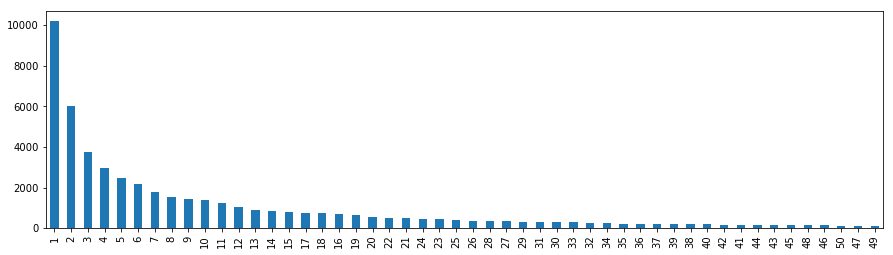

In [450]:
df31 = pd.read_csv('Sales__daily_S031.csv', index_col=[0])
print df31.shape

df31.count(axis=1).value_counts()[:50].plot.bar(figsize=(15, 4));

In [454]:
df31.count(axis=1).describe()

count    53203.000000
mean        16.028983
std         31.376372
min          1.000000
25%          2.000000
50%          6.000000
75%         17.000000
max       1053.000000
dtype: float64

In [456]:
df31.count(axis=1).quantile([0.9, 0.95, 0.97, 0.99])

0.90     40.00
0.95     64.00
0.97     84.00
0.99    133.98
dtype: float64

In [460]:
everyday_items = df31.count(axis=1).sort_values(ascending=False).head().index

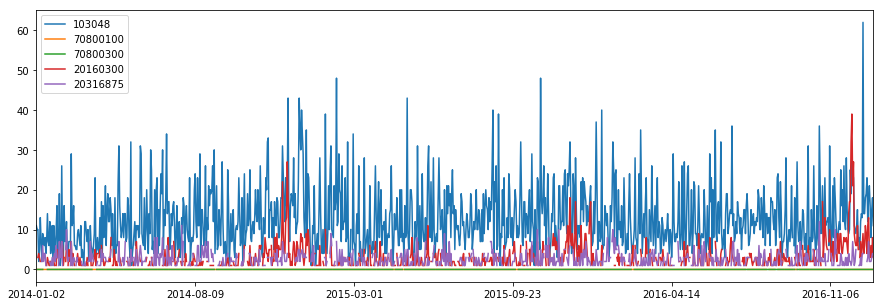

In [465]:
df31.loc[everyday_items].T.plot(figsize=(15, 5))

In [468]:
everyday_items

Int64Index([103048, 70800100, 70800300, 20160300, 20316875], dtype='int64')

In [474]:
!awk -F, '{if($1=="20316875"){print $0}}' Item.csv

20316875,BEKER SNOEP 300 GR,L30026,SWEET PARADISE NV,,1.86,4.99,2,0,32,SN,00,KA,,,1.00,1.00


## MONTHLY sales in WIDE format

- Each product is a row
- Each column is a date

In [340]:
!csvcut -n Sales.csv

  1: store_id
  2: product_id
  3: qty
  4: amt
  5: pd_date
  6: pd_yr_mon_date


In [341]:
!cat Sales.csv \
| csvgrep -c store_id -m "S092" \
| datamash -sH -t, crosstab 2, 6 sum 3 \
| sed 1d \
> Sales__monthly_S092.csv

In [342]:
!cat Sales.csv \
| csvgrep -c store_id -m "S031" \
| datamash -sH -t, crosstab 2, 6 sum 3 \
| sed 1d \
> Sales__monthly_S031.csv

In [436]:
df31 = pd.read_csv('Sales__monthly_S031.csv', index_col=[0])

In [437]:
df31.shape

(53203, 36)

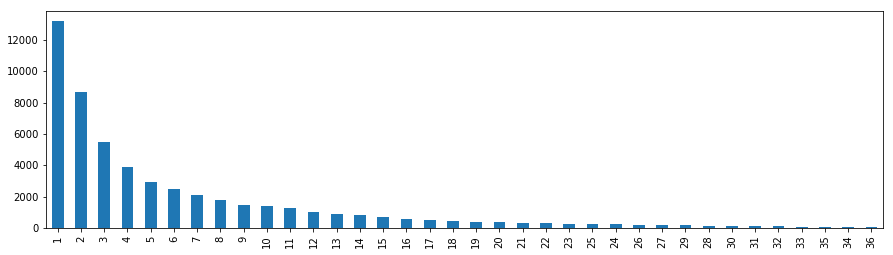

In [438]:
df31.count(axis=1).value_counts()[:50].plot.bar(figsize=(15, 4));

36       6200
34       6500
35       7000
33       9400
32      10400
31      10600
30      13200
28      15400
29      17300
27      17400
26      19500
24      22900
25      24900
23      27600
22      32200
21      32300
20      37300
19      39600
18      43700
17      51300
16      58500
15      68100
14      82400
13      90900
12     104500
11     125800
10     138600
9      149600
8      178700
7      208700
6      247700
5      294100
4      389700
3      551800
2      866000
1     1320500
dtype: int64